In [2]:
import scanpy as sc 
import scrublet as scr
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import os
from scipy.sparse import csr_matrix
import bbknn

/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def process_and_filter_data(adata):
    # Define the filter criteria
    min_genes = 500
    max_genes = 6000
    min_umis = 500
    max_umis = 40000
    max_mito_ratio = 0.10  # 10% mitochondrial genes ratio
    max_ribo_ratio = 0.40  # 40% ribosomal genes ratio

    # Filter cells based on gene counts and UMI counts
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, max_genes=max_genes)
    sc.pp.filter_cells(adata, min_counts=min_umis)
    sc.pp.filter_cells(adata, max_counts=max_umis)

    # Calculate the mitochondrial and ribosomal gene ratios
    mito_genes = adata.var_names.str.startswith('MT-')
    ribo_genes = adata.var_names.str.startswith('RPL') | adata.var_names.str.startswith('RPS')

    # Calculate the mitochondrial and ribosomal gene sums for each cell
    mito_counts = adata[:, mito_genes].X.sum(axis=1)
    ribo_counts = adata[:, ribo_genes].X.sum(axis=1)
    
    # Calculate the mitochondrial and ribosomal gene ratios
    mito_ratio = mito_counts / len(adata.obs['n_counts'])
    ribo_ratio = ribo_counts / len(adata.obs['n_counts'])

    # Filter cells based on mitochondrial and ribosomal gene ratios
    adata = adata[(mito_ratio <= max_mito_ratio) & (ribo_ratio <= max_ribo_ratio), :]

    # Remove the temporary columns used for calculations
    adata.obs.drop(columns=['n_counts'], inplace=True)

    # Scrublet doublet detection
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()

    # Define a threshold for doublet prediction
    doublet_threshold = 0.25

    # Create a boolean mask for doublets
    is_doublet = predicted_doublets > doublet_threshold

    # Filter out doublets from the dataset
    adata = adata[~is_doublet, :]

    return adata

def convert_adata_to_dataframe(adata_dict):
    df_dict = {}

    for name, adata in adata_dict.items():
        df_dict[name] = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)

    return df_dict

def find_zero_columns_indices(df_dict):
    # Initialize with the columns of the first dataframe
    zero_columns_indices = set(df_dict[next(iter(df_dict))].columns)

    # Iterate through the dataframes and find common zero columns
    for df in df_dict.values():
        zero_columns_indices &= set(df.columns[df.eq(0).all()])

    return list(zero_columns_indices)

def filter_and_process_data(adata, zero_columns_indices):
    feature_names_to_keep = [name for i, name in enumerate(adata.var_names) if i not in zero_columns_indices]
    adata_filtered = adata[:, feature_names_to_keep]
    return process_and_filter_data(adata_filtered)

In [4]:
# Define the paths
paths = {
    'Iso_Y_Liver': '/home/dwk681/workspace/CRA004660/Liver/CRR403690_cellranger_output/outs/filtered_feature_bc_matrix',
    'Iso_O_Liver': '/home/dwk681/workspace/CRA004660/Liver/CRR403691_cellranger_output/outs/filtered_feature_bc_matrix',
    'Het_Y_Liver': '/home/dwk681/workspace/CRA004660/Liver/CRR403692_cellranger_output/outs/filtered_feature_bc_matrix',
    'Het_O_Liver': '/home/dwk681/workspace/CRA004660/Liver/CRR403693_cellranger_output/outs/filtered_feature_bc_matrix',
    'Iso_Y_Brain': '/home/dwk681/workspace/CRA004660/Brain/CRR403686_cellranger_output/outs/filtered_feature_bc_matrix',
    'Iso_O_Brain': '/home/dwk681/workspace/CRA004660/Brain/CRR403687_cellranger_output/outs/filtered_feature_bc_matrix',
    'Het_Y_Brain': '/home/dwk681/workspace/CRA004660/Brain/CRR403688_cellranger_output/outs/filtered_feature_bc_matrix',
    'Het_O_Brain': '/home/dwk681/workspace/CRA004660/Brain/CRR403689_cellranger_output/outs/filtered_feature_bc_matrix',
    'Iso_Y_Muscle': '/home/dwk681/workspace/CRA004660/Muscle/CRR403694_cellranger_output/outs/filtered_feature_bc_matrix',
    'Iso_O_Muscle': '/home/dwk681/workspace/CRA004660/Muscle/CRR403695_cellranger_output/outs/filtered_feature_bc_matrix',
    'Het_Y_Muscle': '/home/dwk681/workspace/CRA004660/Muscle/CRR403696_cellranger_output/outs/filtered_feature_bc_matrix',
    'Het_O_Muscle': '/home/dwk681/workspace/CRA004660/Muscle/CRR403697_cellranger_output/outs/filtered_feature_bc_matrix',
    'Het_Y_Muscle_2': '/home/dwk681/workspace/CRA004660/Muscle/CRR477130_cellranger_output/outs/filtered_feature_bc_matrix',
}

# Create a dictionary to store adata objects
adata_dict = {}

# Load data into adata objects
for name, path in paths.items():
    adata_dict[name] = sc.read_10x_mtx(path, cache=True)

df_dict = convert_adata_to_dataframe(adata_dict)
zero_columns_indices = find_zero_columns_indices(df_dict)

filtered_datasets = {}
for name, adata in adata_dict.items():
    filtered_datasets[name] = filter_and_process_data(adata, zero_columns_indices)

FileNotFoundError: Did not find file /home/dwk681/workspace/CRA004660/Liver/CRR403690_cellranger_output/outs/filtered_feature_bc_matrix/matrix.mtx.gz.

In [ ]:
def integrate_and_normalize(adata_dict):
    # Concatenate all datasets
    adata_all = sc.AnnData.concatenate(*adata_dict.values(), batch_key='sample', index_unique='_')

    # Preprocess and filter data
    adata_all = process_and_filter_data(adata_all)

    # Normalize the data
    sc.pp.normalize_total(adata_all)

    # Log transform the data
    sc.pp.log1p(adata_all)

    # Perform batch correction using bbknn
    bbknn.bbknn(adata_all, batch_key='sample')

    return adata_all

# Call the function to integrate and normalize the data
integrated_adata = integrate_and_normalize(filtered_datasets)

In [6]:
import numpy as np
import scanpy as sc

def break_matrix(matrix, chunk_size):
    num_chunks = matrix.shape[0] // chunk_size
    matrix = matrix[:num_chunks * chunk_size, :]  # Discard the last incomplete chunk
    return np.split(matrix, num_chunks, axis=0)

def break_and_label_datasets(adata_dict, chunk_size):
    broken_datasets = {}

    for name, adata in adata_dict.items():
        expression_matrix = adata.X.toarray() 
        broken_matrices = break_matrix(expression_matrix, chunk_size)

        # Create new AnnData objects for each broken matrix
        for i, matrix_chunk in enumerate(broken_matrices):
            new_name = f"{name}_Block{i + 1}"

            # Create a subset of the original obs annotation
            obs_subset = adata.obs.iloc[i * chunk_size: (i + 1) * chunk_size, :]

            new_adata = sc.AnnData(X=matrix_chunk, var=adata.var, obs=obs_subset)
            broken_datasets[new_name] = new_adata

    return broken_datasets

# Assuming chunk size is 100
chunk_size = 100

# Assuming filtered_datasets is your dictionary of AnnData objects
broken_datasets = break_and_label_datasets(filtered_datasets, chunk_size)



In [8]:
#All the count matrices are normalized

def normalize_ann_datasets(adata_dict):
    normalized_datasets = {}

    for name, adata in adata_dict.items():
        data_matrix = adata.X

        # Ensure all values are non-negative
        data_matrix = np.maximum(data_matrix, 0)

        # Log transformation
        normalized_matrix = np.log(data_matrix + 1)

        # Robust scaling based on the interquartile range (IQR)
        q75, q25 = np.percentile(normalized_matrix, [75 ,25])
        iqr = q75 - q25
        normalized_matrix = (normalized_matrix - q25) / (iqr + 1e-10)

        # Create a new AnnData object for the normalized matrix
        new_name = f'Normalized_{name}'
        new_adata = sc.AnnData(X=normalized_matrix, var=adata.var, obs=adata.obs)
        normalized_datasets[new_name] = new_adata

    return normalized_datasets


# Assuming adata_dict is your dictionary of AnnData objects
normalized_datasets = normalize_ann_datasets(broken_datasets)


In [11]:
def find_minimum_value_in_normalized_datasets(normalized_datasets):
    min_value = float('inf')  # Initialize with positive infinity to ensure any value is smaller

    for name, adata in normalized_datasets.items():
        # Extract the X matrix from the AnnData object
        normalized_matrix = adata.X

        # Find the minimum value in the current normalized matrix
        current_min_value = np.min(normalized_matrix)

        # Update the overall minimum value if the current matrix has a smaller minimum
        min_value = min(min_value, current_min_value)

    return min_value

minimum_value = find_minimum_value_in_normalized_datasets(normalized_datasets)

print(f"The minimum value in all normalized matrices is: {minimum_value}")

The minimum value in all normalized matrices is: 0.0


In [12]:
def combine_matrices_into_tensor(normalized_datasets):
    matrices_list = [adata.X for adata in normalized_datasets.values()]
    stacked_tensor = np.stack(matrices_list, axis=0)
    return stacked_tensor

combined_tensor = combine_matrices_into_tensor(normalized_datasets)

print("Shape of the combined tensor:", combined_tensor.shape)

Shape of the combined tensor: (2600, 100, 32285)


In [18]:
import h5py

def save_to_hdf5(file_path, tensor, dataset_names, variable_names):
    with h5py.File(file_path, 'w') as hf:
        hf.create_dataset('tensor', data=tensor)

        # Save the vector of dataset names
        dt = h5py.special_dtype(vlen=str)
        dataset_names_ds = hf.create_dataset('dataset_names', shape=(len(dataset_names),), dtype=dt)
        dataset_names_ds[...] = dataset_names

        # Save the vector of variable names
        variable_names_ds = hf.create_dataset('variable_names', shape=(len(variable_names),), dtype=dt)
        variable_names_ds[...] = variable_names

dataset_names = list(normalized_datasets.keys())
variable_names = list(normalized_datasets[dataset_names[0]].var_names)  

save_to_hdf5('/home/dwk681/workspace/CRA004660/normalized_tensor.h5', combined_tensor, dataset_names, variable_names)


NameError: name 'dataset_names' is not defined

(4273, 27030)
(9052, 27030)
(14029, 27030)
(11518, 27030)


(4273, 27030)
(4273, 27030)
(4273, 27030)
(4273, 27030)


(4273, 27030)
(4273, 27030)
(4273, 27030)
(4273, 27030)


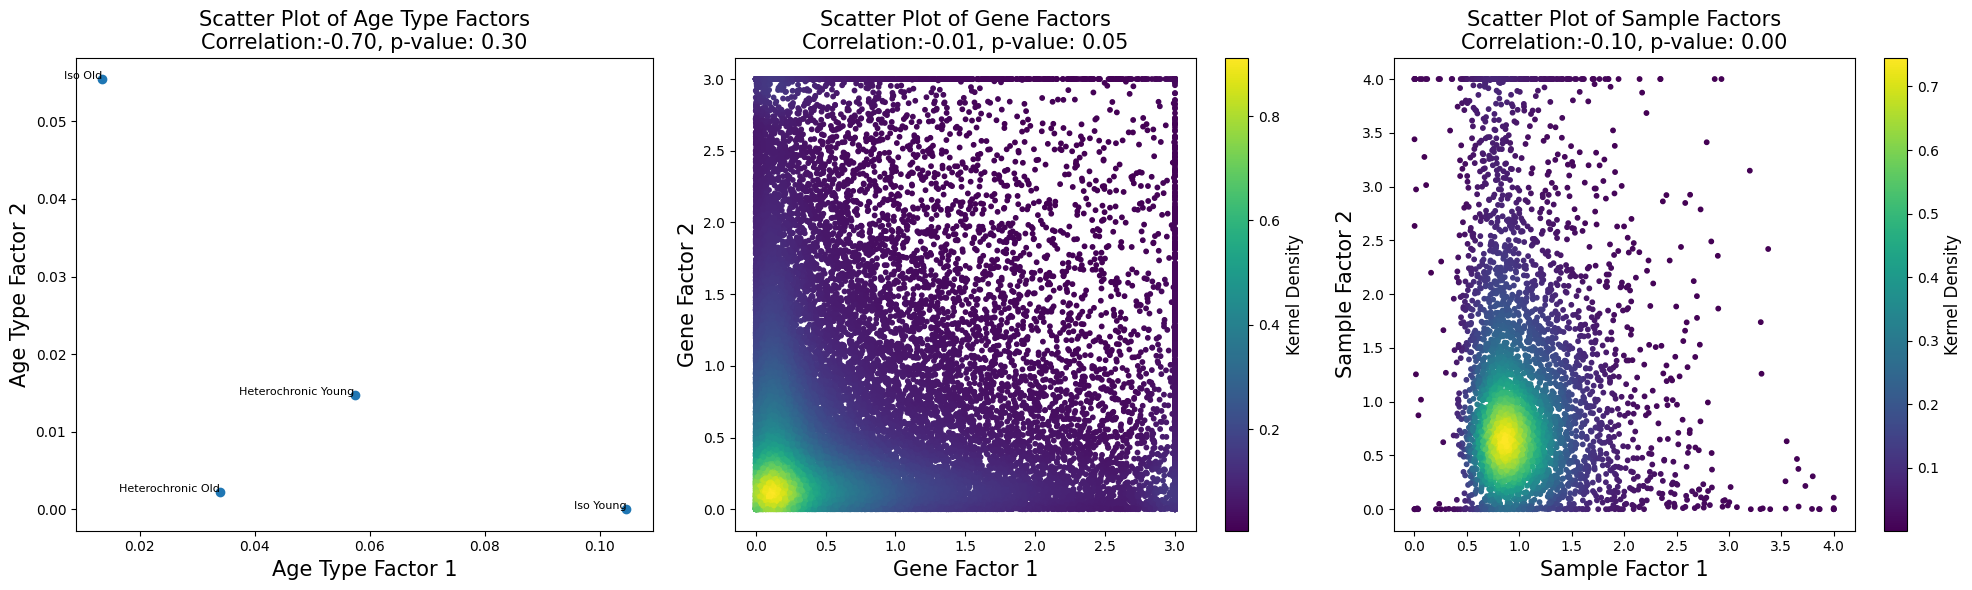

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, gaussian_kde
import scipy.io
import numpy as np

mat_data = scipy.io.loadmat('/home/dwk681/workspace/CRA004660_new/Liver/Workspaces/minRows_structuredData_all4_first3_200iterations_highmem_nozscores.mat')
sol_factors = mat_data['sol_factors']

r = 2

age_type_factor1 = sol_factors[0][2][0][2][:, 2]
age_type_factor2 = sol_factors[0][2][0][2][:, 1]

sample_factor1 = sol_factors[0][2][0][1][:, 2]
sample_factor2 = sol_factors[0][2][0][1][:, 1]
threshold=4
sample_factor1[sample_factor1 > threshold] = threshold
sample_factor2[sample_factor2 > threshold] = threshold


gene_factor1 = sol_factors[0][2][0][0][:, 2]
gene_factor2 = sol_factors[0][2][0][0][:, 1]
threshold=3
gene_factor1[gene_factor1 > threshold] = threshold
gene_factor2[gene_factor2 > threshold] = threshold

# Calculate kernel density manually
kde_gene = gaussian_kde(np.vstack([gene_factor1, gene_factor2]))
density_gene = kde_gene(np.vstack([gene_factor1, gene_factor2]))

kde_sample = gaussian_kde(np.vstack([sample_factor1, sample_factor2]))
density_sample = kde_sample(np.vstack([sample_factor1, sample_factor2]))

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

correlation, p_value = pearsonr(age_type_factor1, age_type_factor2)
scatter1 = ax1.scatter(age_type_factor1, age_type_factor2)
ax1.set_title(f'Scatter Plot of Age Type Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax1.set_xlabel('Age Type Factor 1', fontsize=15)
ax1.set_ylabel('Age Type Factor 2', fontsize=15)
# Manually label points in Age Type Factors plot with words
labels = ['Iso Young', 'Iso Old', 'Heterochronic Young', 'Heterochronic Old']
for label, x, y in zip(labels, age_type_factor1, age_type_factor2):
    ax1.text(x, y, label, fontsize=8, ha='right')

# Scatter plot for Gene Factors
correlation, p_value = pearsonr(gene_factor1, gene_factor2)
scatter2 = ax2.scatter(gene_factor1, gene_factor2,  c=density_gene, cmap='viridis', s=10)
ax2.set_title(f'Scatter Plot of Gene Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax2.set_xlabel('Gene Factor 1', fontsize=15)
ax2.set_ylabel('Gene Factor 2', fontsize=15)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Kernel Density', fontsize=12)

# Scatter plot for Sample Factors with manual kernel density and color bar
correlation, p_value = pearsonr(sample_factor1, sample_factor2)
scatter3 = ax3.scatter(sample_factor1, sample_factor2, c=density_sample, cmap='viridis', s=10)
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Kernel Density', fontsize=12)
ax3.set_title(f'Scatter Plot of Sample Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax3.set_xlabel('Sample Factor 1', fontsize=15)
ax3.set_ylabel('Sample Factor 2', fontsize=15)

plt.tight_layout()
plt.show()

    


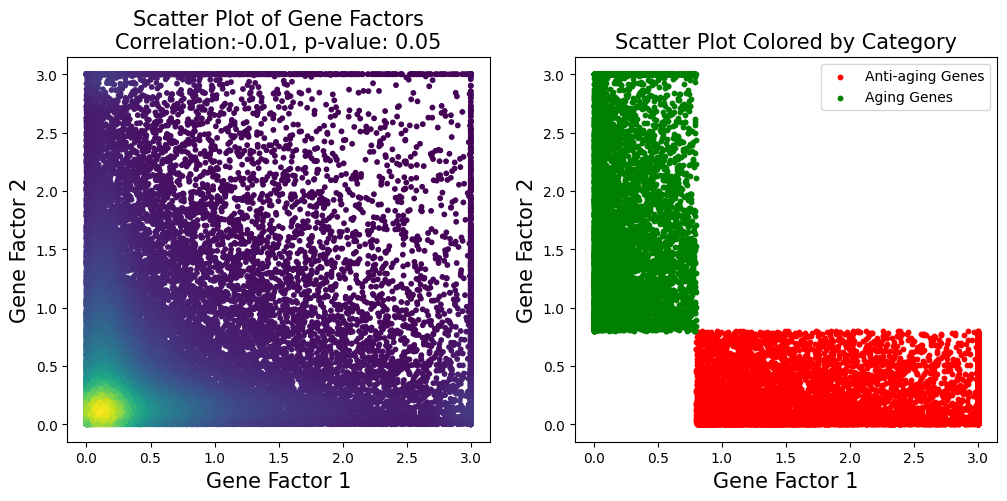

In [37]:
def categorize_vectors(vector1, vector2):
    # Step 1: Calculate average values
    avg_vector1 = np.mean(vector1)
    avg_vector2 = np.mean(vector2)

    # Step 2 and 3: Create and populate categories
    category1 = [i for i in range(len(vector1)) if vector1[i] > avg_vector1 and vector2[i] < avg_vector2]
    category2 = [i for i in range(len(vector2)) if vector2[i] > avg_vector2 and vector1[i] < avg_vector1]

    return category1, category2

category1, category2 = categorize_vectors(gene_factor1, gene_factor2)

kde_gene = gaussian_kde(np.vstack([gene_factor1, gene_factor2]))
density_gene = kde_gene(np.vstack([gene_factor1, gene_factor2]))

# Scatter plot with color by category
correlation, p_value = pearsonr(gene_factor1, gene_factor2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Your original scatter plot for correlation and p-value
scatter1 = ax1.scatter(gene_factor1, gene_factor2,  c=density_gene, cmap='viridis', s=10)
ax1.set_title(f'Scatter Plot of Gene Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax1.set_xlabel('Gene Factor 1', fontsize=15)
ax1.set_ylabel('Gene Factor 2', fontsize=15)

# Scatter plot colored by category
scatter2 = ax2.scatter([gene_factor1[i] for i in category1], [gene_factor2[i] for i in category1], c='red', label='Anti-aging Genes', s=10)
scatter3 = ax2.scatter([gene_factor1[i] for i in category2], [gene_factor2[i] for i in category2], c='green', label='Aging Genes', s=10)
ax2.set_title('Scatter Plot Colored by Category', fontsize=15)
ax2.set_xlabel('Gene Factor 1', fontsize=15)
ax2.set_ylabel('Gene Factor 2', fontsize=15)
ax2.legend()

plt.show()



In [87]:
len(variable_names)

27030

In [117]:
'''
output_directory = '/home/dwk681/workspace/CRA004660_new/Liver/'
filename = "all_four_removed_rows_filtered_zscores_columns.mat"
file_path = output_directory + filename

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Get the 'feature_names' dataset
    feature_names_dataset = f['feature_names']
    
    # Get the feature_names vector
    feature_names = feature_names_dataset[:]
    
    # Get the length of the feature_names vector
    feature_names_length = len(feature_names)

print("Feature Names:", feature_names)
print("Length of Feature Names:", feature_names_length)
'''

# Filter feature_names into three new vectors
genes_in_category1 = [variable_names[i] for i in category1]
genes_in_category2 = [variable_names[i] for i in category2]
genes_in_either_category = np.union1d(category1, category2)  # Assuming no duplicates
    
genes_in_either_category_vector = [variable_names[i] for i in genes_in_either_category]

print(len(genes_in_category1))
print(len(genes_in_category2))
print(len(genes_in_either_category_vector))

for item in genes_in_category2:
    print(item)




6272
6335
12607
GRCh38_AURKAIP1
GRCh38_RBP7
GRCh38_CASZ1
GRCh38_TMEM51-AS1
GRCh38_EFHD2
GRCh38_DDI2
GRCh38_MICOS10
GRCh38_CDC42
GRCh38_ID3
GRCh38_NIPAL3
GRCh38_RUNX3
GRCh38_SELENON
GRCh38_MTFR1L
GRCh38_SH3BGRL3
GRCh38_NUDC
GRCh38_WDTC1
GRCh38_XKR8
GRCh38_ATP5IF1
GRCh38_SNHG3
GRCh38_PTP4A2
GRCh38_KHDRBS1
GRCh38_EIF3I
GRCh38_TSSK3
GRCh38_KIAA1522
GRCh38_THRAP3
GRCh38_MEAF6
GRCh38_RRAGC
GRCh38_MACF1
GRCh38_CAP1
GRCh38_RIMKLA
GRCh38_YBX1
GRCh38_EIF2B3
GRCh38_MMACHC
GRCh38_SPATA6
GRCh38_MRPL37
GRCh38_DHCR24
GRCh38_PLPP3
GRCh38_PRKAA2
GRCh38_NFIA
GRCh38_NFIA-AS2
GRCh38_EFCAB7
GRCh38_GNG12
GRCh38_SRSF11
GRCh38_ANKRD13C
GRCh38_ZRANB2
GRCh38_GNG5
GRCh38_ZNHIT6
GRCh38_GBP4
GRCh38_MTF2
GRCh38_TMED5
GRCh38_GCLM
GRCh38_AMIGO1
GRCh38_LAMTOR5
GRCh38_DDX20
GRCh38_CTTNBP2NL
GRCh38_WNT2B
GRCh38_SLC16A1-AS1
GRCh38_TENT5C
GRCh38_PHGDH
GRCh38_AC245014.3
GRCh38_HIST2H2AC
GRCh38_PLEKHO1
GRCh38_CTSS
GRCh38_CERS2
GRCh38_GABPB2
GRCh38_PSMD4
GRCh38_PSMB4
GRCh38_S100A9
GRCh38_S100A7
GRCh38_S100A4
GRCh38_CRTC2
GRC

In [91]:
# Your existing code for reading anndata objects
path_Iso_Y = '/home/dwk681/workspace/CRA004660_new/Liver/CRR403690_Liver-Iso-Y/CRR403690/outs/filtered_feature_bc_matrix'
adata_Iso_Y = sc.read_10x_mtx(path_Iso_Y, cache=True)

path_Het_Y = '/home/dwk681/workspace/CRA004660_new/Liver/CRR403692_Liver-Het-Y/CRR403692/outs/filtered_feature_bc_matrix'
adata_Het_Y = sc.read_10x_mtx(path_Het_Y, cache=True)

path_Iso_O = '/home/dwk681/workspace/CRA004660_new/Liver/CRR403691_Liver-Iso-O/CRR403691/outs/filtered_feature_bc_matrix'
adata_Iso_O = sc.read_10x_mtx(path_Iso_O, cache=True)

path_Het_O = '/home/dwk681/workspace/CRA004660_new/Liver/CRR403693_Liver-Het-O/CRR403693/outs/filtered_feature_bc_matrix/'
adata_Het_O = sc.read_10x_mtx(path_Het_O, cache=True)

#gene_names_to_match = [gene_name.decode('utf-8')[0:-1] for gene_name in genes_in_either_category_vector]
gene_names_to_match = genes_in_either_category_vector

# Filter columns (genes) in anndata objects
adata_Iso_Y = adata_Iso_Y[:, adata_Iso_Y.var_names.isin(gene_names_to_match)]
adata_Het_Y = adata_Het_Y[:, adata_Het_Y.var_names.isin(gene_names_to_match)]
adata_Iso_O = adata_Iso_O[:, adata_Iso_O.var_names.isin(gene_names_to_match)]
adata_Het_O = adata_Het_O[:, adata_Het_O.var_names.isin(gene_names_to_match)]



In [96]:
# Process and filter the data (assuming 'process_and_filter_data' is a function)
adata_Iso_Y_filtered = process_and_filter_data(adata_Iso_Y)
adata_Iso_O_filtered = process_and_filter_data(adata_Iso_O)
adata_Het_Y_filtered = process_and_filter_data(adata_Het_Y)
adata_Het_O_filtered = process_and_filter_data(adata_Het_O)

print(adata_Iso_Y_filtered.X.nnz)
print(adata_Iso_O_filtered.X.nnz)
print(adata_Het_Y_filtered.X.nnz)
print(adata_Het_O_filtered.X.nnz)

/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 7.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 28.6%
Elapsed time: 0.6 seconds


/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 16.7%
Elapsed time: 2.2 seconds


/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 36.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.9%
Elapsed time: 3.7 seconds


/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 2.4 seconds
637553
3053142
4643457
3589085


In [112]:
type(adata_Iso_Y_filtered.X.toarray())

numpy.ndarray

In [114]:
min_rows = min(len(adata_Iso_Y_filtered.X.toarray()),
              len(adata_Iso_O_filtered.X.toarray()),
              len(adata_Het_Y_filtered.X.toarray()),
              len(adata_Het_O_filtered.X.toarray()))

Iso_Y = adata_Iso_Y_filtered[:min_rows, :]
Iso_O = adata_Iso_O_filtered[:min_rows, :]
Het_Y = adata_Het_Y_filtered[:min_rows, :]
Het_O = adata_Het_O_filtered[:min_rows, :]

print(Iso_Y.shape)
print(Iso_O.shape)
print(Het_Y.shape)
print(Het_O.shape)

output_directory = '/home/dwk681/workspace/CRA004660_new/Liver/'
filename = "all_four_genes_filtered_count_matrices.mat" 

# Create an HDF5 file and save the count matrices
with h5py.File(output_directory + f'{filename}', 'w') as f:
    f.create_dataset('Iso_Y', data=adata_Iso_Y_filtered.X.toarray())
    f.create_dataset('Iso_O', data=adata_Iso_O_filtered.X.toarray())
    f.create_dataset('Het_Y', data=adata_Het_Y_filtered.X.toarray())
    f.create_dataset('Het_O', data=adata_Het_O_filtered.X.toarray())

(933, 12607)
(933, 12607)
(933, 12607)
(933, 12607)


In [122]:
new_genes = Het_O.var_names

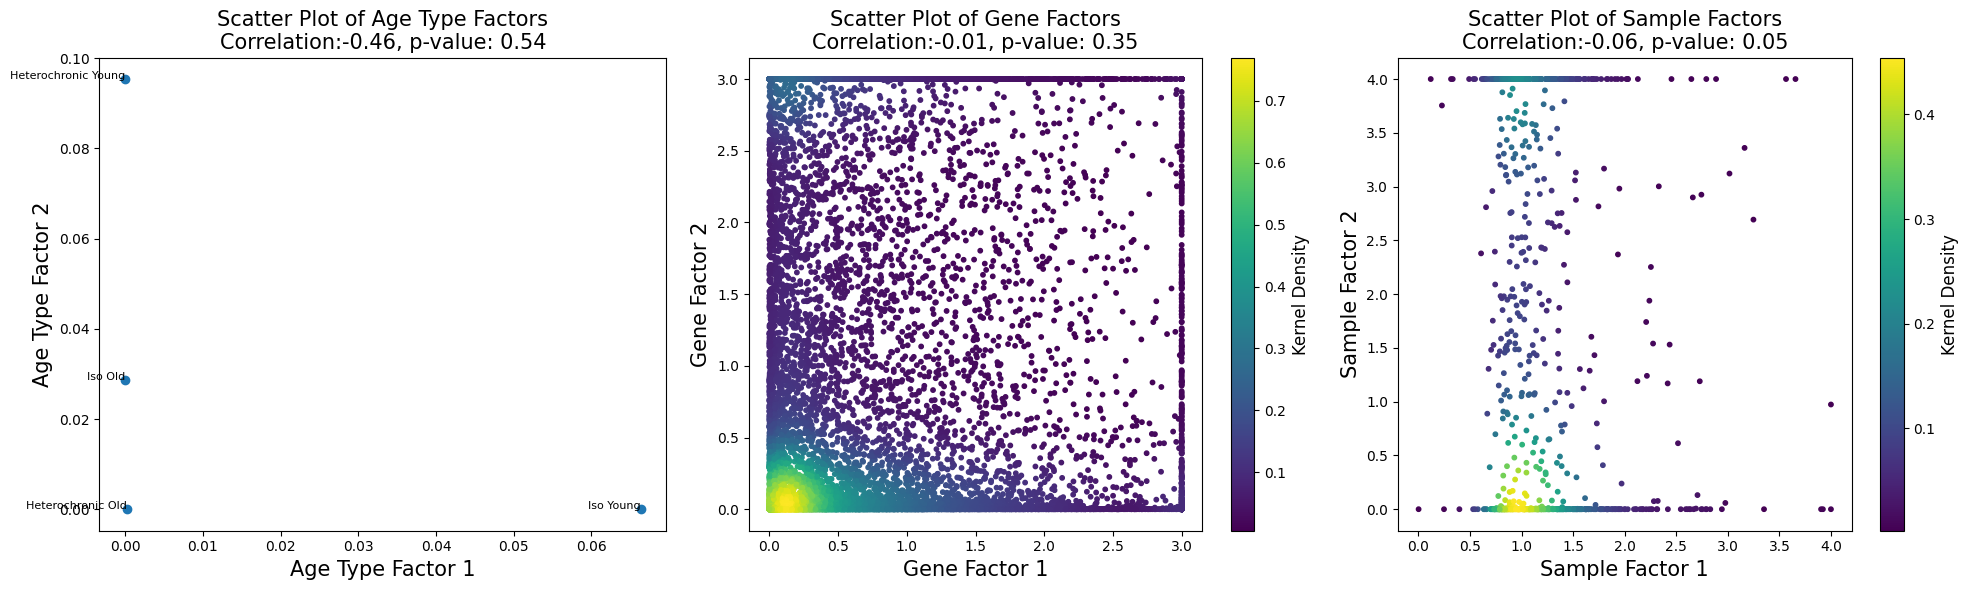

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, gaussian_kde
import scipy.io
import numpy as np

mat_data = scipy.io.loadmat('/home/dwk681/workspace/CRA004660_new/Liver/Workspaces/minRows_genefiltered_structuredData_all4_first3_500iterations_highmem.mat')
sol_factors = mat_data['sol_factors']

age_type_factor1 = sol_factors[0][1][0][2][:, 0]
age_type_factor2 = sol_factors[0][1][0][2][:, 1]

sample_factor1 = sol_factors[0][1][0][1][:, 0]
sample_factor2 = sol_factors[0][1][0][1][:, 1]
threshold=4
sample_factor1[sample_factor1 > threshold] = threshold
sample_factor2[sample_factor2 > threshold] = threshold


gene_factor1 = sol_factors[0][1][0][0][:, 0]
gene_factor2 = sol_factors[0][1][0][0][:, 1]
threshold=3
gene_factor1[gene_factor1 > threshold] = threshold
gene_factor2[gene_factor2 > threshold] = threshold

# Calculate kernel density manually
kde_gene = gaussian_kde(np.vstack([gene_factor1, gene_factor2]))
density_gene = kde_gene(np.vstack([gene_factor1, gene_factor2]))

kde_sample = gaussian_kde(np.vstack([sample_factor1, sample_factor2]))
density_sample = kde_sample(np.vstack([sample_factor1, sample_factor2]))

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

correlation, p_value = pearsonr(age_type_factor1, age_type_factor2)
scatter1 = ax1.scatter(age_type_factor1, age_type_factor2)
ax1.set_title(f'Scatter Plot of Age Type Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax1.set_xlabel('Age Type Factor 1', fontsize=15)
ax1.set_ylabel('Age Type Factor 2', fontsize=15)
# Manually label points in Age Type Factors plot with words
labels = ['Iso Young', 'Iso Old', 'Heterochronic Young', 'Heterochronic Old']
for label, x, y in zip(labels, age_type_factor1, age_type_factor2):
    ax1.text(x, y, label, fontsize=8, ha='right')

# Scatter plot for Gene Factors
correlation, p_value = pearsonr(gene_factor1, gene_factor2)
scatter2 = ax2.scatter(gene_factor1, gene_factor2,  c=density_gene, cmap='viridis', s=10)
ax2.set_title(f'Scatter Plot of Gene Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax2.set_xlabel('Gene Factor 1', fontsize=15)
ax2.set_ylabel('Gene Factor 2', fontsize=15)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Kernel Density', fontsize=12)

# Scatter plot for Sample Factors with manual kernel density and color bar
correlation, p_value = pearsonr(sample_factor1, sample_factor2)
scatter3 = ax3.scatter(sample_factor1, sample_factor2, c=density_sample, cmap='viridis', s=10)
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Kernel Density', fontsize=12)
ax3.set_title(f'Scatter Plot of Sample Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax3.set_xlabel('Sample Factor 1', fontsize=15)
ax3.set_ylabel('Sample Factor 2', fontsize=15)

plt.tight_layout()
plt.show()

    


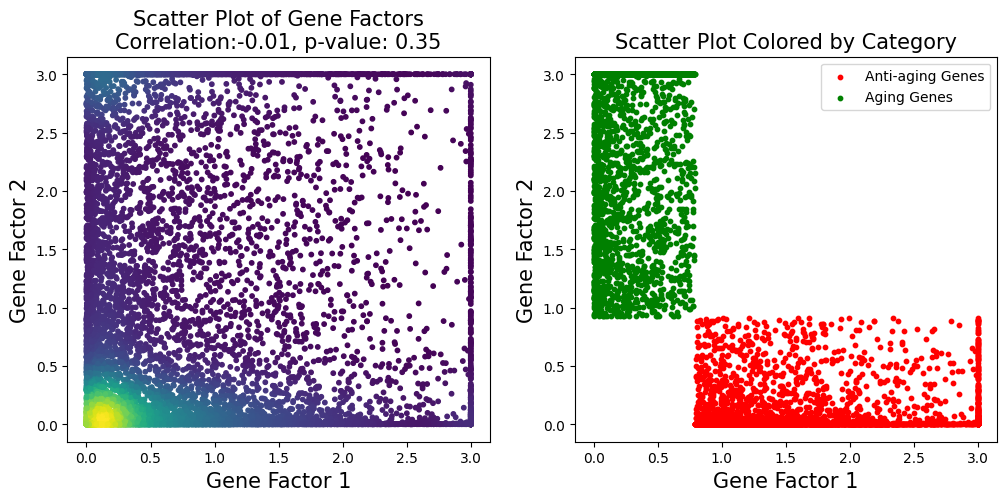

In [141]:
category1, category2 = categorize_vectors(gene_factor1, gene_factor2)
kde_gene = gaussian_kde(np.vstack([gene_factor1, gene_factor2]))
density_gene = kde_gene(np.vstack([gene_factor1, gene_factor2]))

# Scatter plot with color by category
correlation, p_value = pearsonr(gene_factor1, gene_factor2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Your original scatter plot for correlation and p-value
scatter1 = ax1.scatter(gene_factor1, gene_factor2,  c=density_gene, cmap='viridis', s=10)
ax1.set_title(f'Scatter Plot of Gene Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}', fontsize=15)
ax1.set_xlabel('Gene Factor 1', fontsize=15)
ax1.set_ylabel('Gene Factor 2', fontsize=15)

# Scatter plot colored by category
scatter2 = ax2.scatter([gene_factor1[i] for i in category1], [gene_factor2[i] for i in category1], c='red', label='Anti-aging Genes', s=10)
scatter3 = ax2.scatter([gene_factor1[i] for i in category2], [gene_factor2[i] for i in category2], c='green', label='Aging Genes', s=10)
ax2.set_title('Scatter Plot Colored by Category', fontsize=15)
ax2.set_xlabel('Gene Factor 1', fontsize=15)
ax2.set_ylabel('Gene Factor 2', fontsize=15)
ax2.legend()

plt.show()


In [142]:
# Filter feature_names into three new vectors
#factor2 is aging factor
#factor1 is youth factor
genes_in_category1_filtered = [new_genes[i] for i in category1]
genes_in_category2_filtered = [new_genes[i] for i in category2]
genes_in_either_category_filtered = np.union1d(category1, category2)  # Assuming no duplicates
    
genes_in_either_category_vector_filtered = [new_genes[i] for i in genes_in_either_category_filtered]



In [148]:
gene_names_category1_new = [gene_name.split('_')[1] for gene_name in genes_in_category1_filtered]
gene_names_category2_new = [gene_name.split('_')[1] for gene_name in genes_in_category2_filtered]


3093
2845


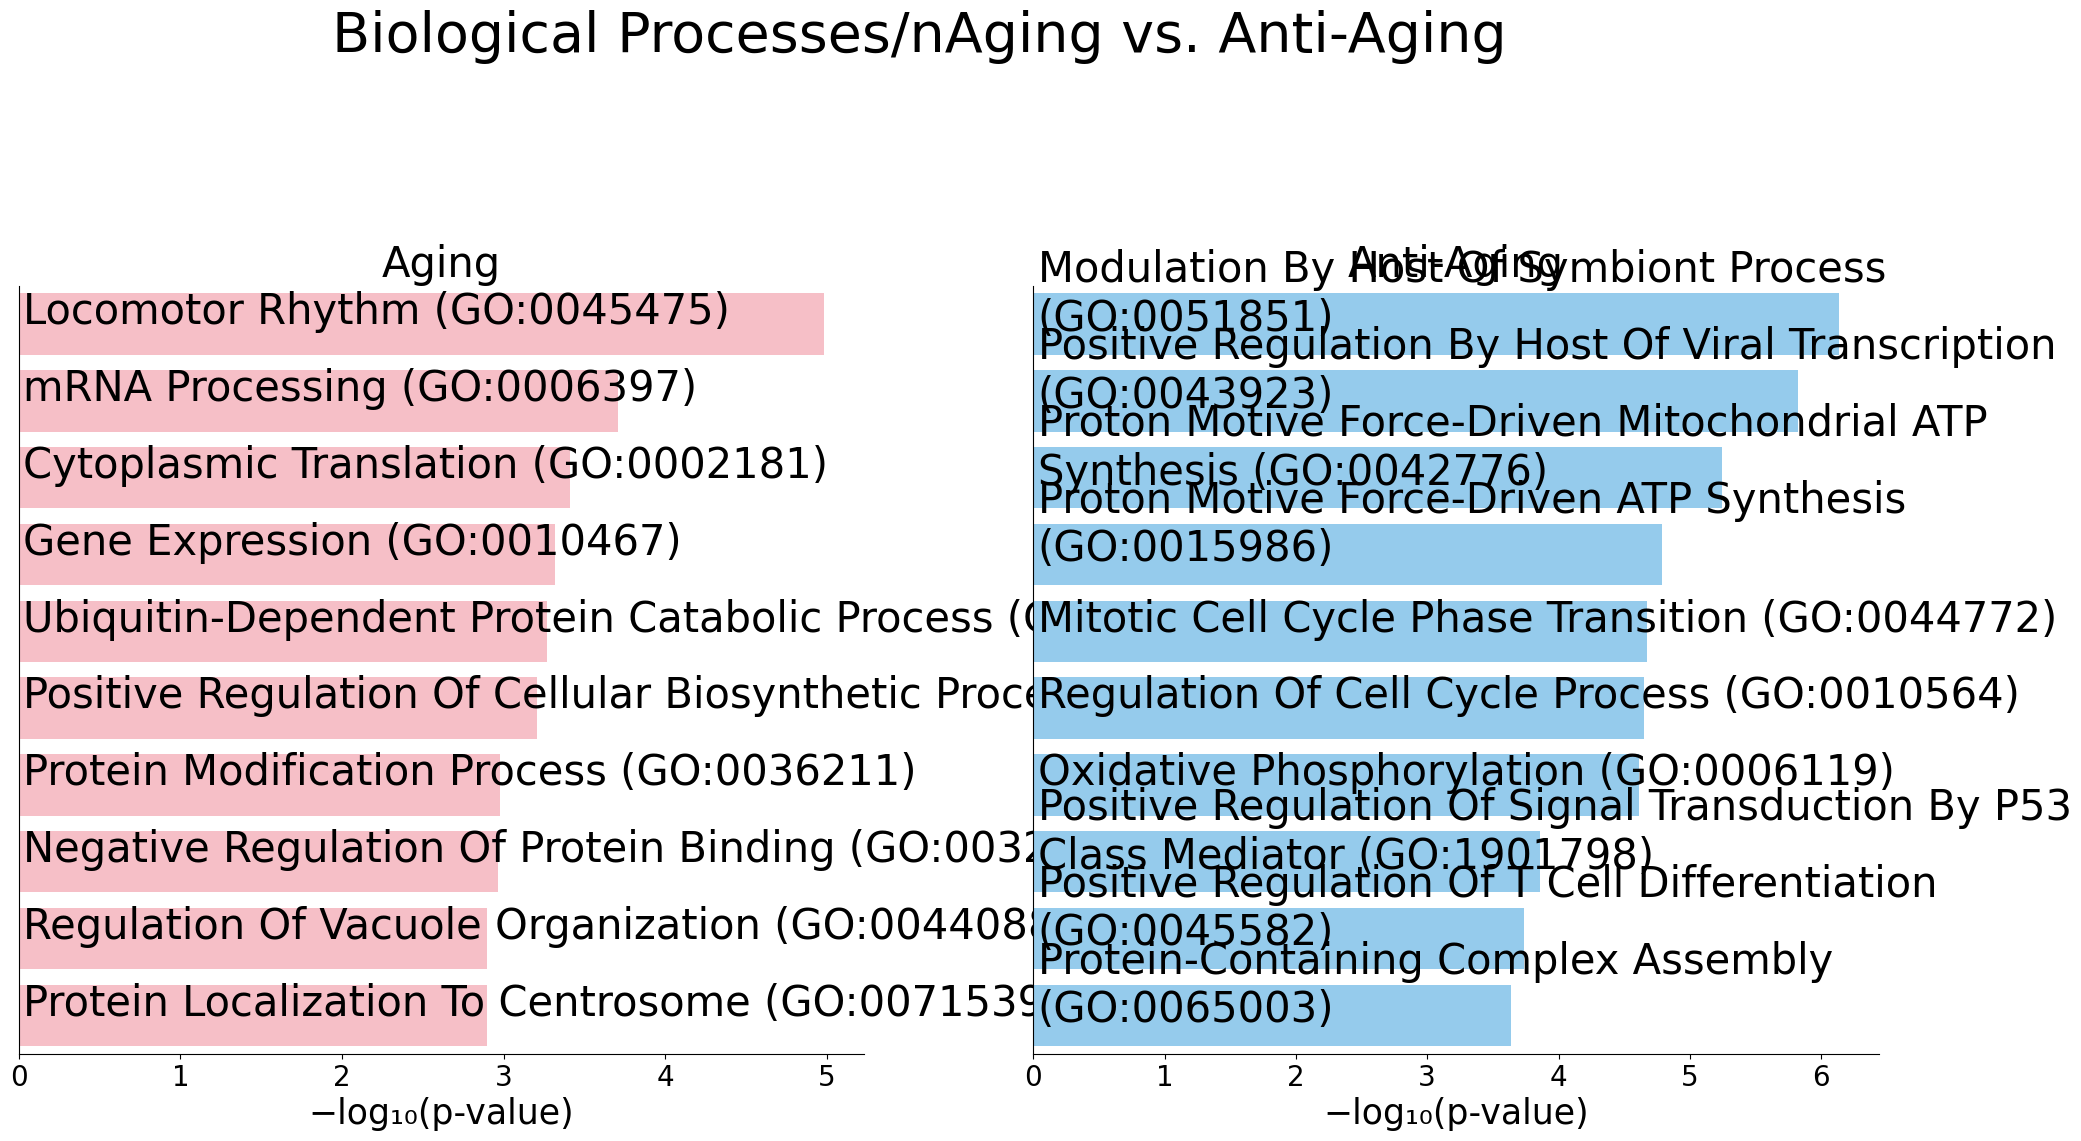

**Figure 1. Bar chart of top enriched terms from the GO_Biological_Process_2023 gene set library.** The top 5     enriched upregulated and downregulated terms for the input gene set are displayed based on the -log10(p-value).

/projects/b1198/epifluidlab/david/CRA004660_new/Liver/Enrichr_results_bar.png

/projects/b1198/epifluidlab/david/CRA004660_new/Liver/Enrichr_results_bar.svg

In [151]:
# Bar Chart Imports
import pandas as pd 
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import time
from matplotlib.ticker import MaxNLocator
from IPython.display import display, FileLink, HTML, Markdown

# Bar Chart Parameters
figure_file_format = ['png', 'svg']
output_file_name = 'Enrichr_results_bar'
color = 'lightskyblue'
final_output_file_names = ['{0}.{1}'.format(output_file_name, file_type) for file_type in figure_file_format]
#enrichr_library = 'MSigDB_Hallmark_2020'
enrichr_library = 'GO_Biological_Process_2023'


gene_list_input_down = gene_names_category1_new
print(len(gene_list_input_down)) # anti_aging
genes_downregulated = [x.strip() for x in gene_list_input_down]

gene_list_input_up = gene_names_category2_new
print(len(gene_list_input_up)) #aging
genes_upregulated = [x.strip() for x in gene_list_input_up]

# Error handling
class NoResults(Exception):
    pass 
class APIFailure(Exception):
    pass

# Enrichr API Function for Manhattan Plot and Bar Chart
# Takes a gene list and Enrichr libraries as input
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    for library_name in all_libraries : 
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = ''
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)

        if len(data[library_name]) == 0:
            raise NoResults

        short_results_df  = pd.DataFrame(data[library_name][0:10])
        all_terms.append(list(short_results_df[1]))
        all_pvalues.append(list(short_results_df[2]))
        all_adjusted_pvalues.append(list(short_results_df[6]))
        
        results_df  = pd.DataFrame(data[library_name])
        # adds library name to the data frame so the libraries can be distinguished
        results_df['library'] = library_name.replace('_', '')

    return [results_df, short_results_df, all_terms, all_pvalues, all_adjusted_pvalues, str(short_id)]

def enrichr_double_figure(up_terms, up_pvalues, up_adjusted_pvalues, down_terms, down_pvalues, down_adjusted_pvalues, plot_names, all_libraries, up_title, down_title):
    # Set bar colors
    edgecolor=None
    linewidth=0
    up_bar_color =  'lightpink'  #shade of red
    down_bar_color = 'lightskyblue'  #shade of blue
    
    plt.figure(figsize=(24, 12))

    # Add a title to the figure
    plt.suptitle("Biological Processes/nAging vs. Anti-Aging", fontsize=40)
    plt.subplots_adjust(top=0.75)
    # Flatten the nested lists of terms
    up_terms_flat = [term for sublist in up_terms for term in sublist]
    down_terms_flat = [term for sublist in down_terms for term in sublist]

    # Flatten the nested lists of p-values
    up_pvalues_flat = [p for sublist in up_pvalues for p in sublist]
    down_pvalues_flat = [p for sublist in down_pvalues for p in sublist]

    # Plot for upregulated genes
    plt.subplot(1, 2, 1)
    up_bar_colors = [up_bar_color if (x < 0.05) else bar_color_not_sig for x in up_pvalues_flat]
    up_fig = sns.barplot(x=np.log10(up_pvalues_flat) * -1, y=up_terms_flat, palette=up_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    up_fig.axes.get_yaxis().set_visible(False)
    up_fig.set_title(up_title, fontsize=30)
    up_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    up_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    up_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(up_pvalues_flat) * -1) < 1:
        up_fig.xaxis.set_ticks(np.arange(0, max(np.log10(up_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(up_terms_flat):
        title_start = max(up_fig.axes.get_xlim()) / 200
        up_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=30)
    up_fig.spines['right'].set_visible(False)
    up_fig.spines['top'].set_visible(False)

    # Plot for downregulated genes
    plt.subplot(1, 2, 2)
    down_bar_colors = [down_bar_color if (x < 0.05) else bar_color_not_sig for x in down_pvalues_flat]
    down_fig = sns.barplot(x=np.log10(down_pvalues_flat) * -1, y=down_terms_flat, palette=down_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    down_fig.axes.get_yaxis().set_visible(False)
    down_fig.set_title(down_title, fontsize=30)
    down_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    down_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    down_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(down_pvalues_flat) * -1) < 1:
        down_fig.xaxis.set_ticks(np.arange(0, max(np.log10(down_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(down_terms_flat):
        title_start = max(down_fig.axes.get_xlim()) / 200
        down_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=30)
    down_fig.spines['right'].set_visible(False)
    down_fig.spines['top'].set_visible(False)

    for plot_name in plot_names:
        plt.savefig(plot_name, bbox_inches='tight')

    # Show plot
    plt.show()
#Display Bar Chart
caption5 = f"**Figure 1. Bar chart of top enriched terms from the {enrichr_library} gene set library.** The top 5 \
    enriched upregulated and downregulated terms for the input gene set are displayed based on the -log10(p-value)."

try:
    results_upregulated = Enrichr_API(genes_upregulated, [enrichr_library])
    results_downregulated = Enrichr_API(genes_downregulated, [enrichr_library])
    upregulated_title = 'Aging'
    downregulated_title = 'Anti-Aging'
    enrichr_double_figure(results_upregulated[2], results_upregulated[3], results_upregulated[4],
                      results_downregulated[2], results_downregulated[3], results_downregulated[4],
                      final_output_file_names, [enrichr_library], upregulated_title, downregulated_title)
    display(Markdown(caption5))
    # Download Bar Chart
    for i, file in enumerate(final_output_file_names):
        display(FileLink(file, result_html_prefix=str('Download ' + figure_file_format[i] + ': ')))
except APIFailure:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because of a bad response from the Enrichr API</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later."))
except NoResults:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))

['GRCh38_RER1',
 'GRCh38_MIR34AHG',
 'GRCh38_RBP7',
 'GRCh38_TARDBP',
 'GRCh38_MICOS10',
 'GRCh38_CDC42',
 'GRCh38_LUZP1',
 'GRCh38_ID3',
 'GRCh38_PNRC2',
 'GRCh38_RUNX3',
 'GRCh38_SELENON',
 'GRCh38_XKR8',
 'GRCh38_ATP5IF1',
 'GRCh38_SNHG3',
 'GRCh38_KHDRBS1',
 'GRCh38_EIF3I',
 'GRCh38_CAP1',
 'GRCh38_YBX1',
 'GRCh38_EFCAB14',
 'GRCh38_ZYG11B',
 'GRCh38_PRKAA2',
 'GRCh38_ITGB3BP',
 'GRCh38_ANKRD13C',
 'GRCh38_LAMTOR5',
 'GRCh38_ATP5PB',
 'GRCh38_WNT2B',
 'GRCh38_TENT5C',
 'GRCh38_AC245014.3',
 'GRCh38_HIST2H2AC',
 'GRCh38_ATP8B2',
 'GRCh38_SHC1',
 'GRCh38_GPATCH4',
 'GRCh38_PRCC',
 'GRCh38_DCAF8',
 'GRCh38_F11R',
 'GRCh38_PRRC2C',
 'GRCh38_PRDX6',
 'GRCh38_GAS5',
 'GRCh38_SOAT1',
 'GRCh38_PLA2G4A',
 'GRCh38_RGS2',
 'GRCh38_UBE2T',
 'GRCh38_ELK4',
 'GRCh38_RASSF5',
 'GRCh38_TRAF5',
 'GRCh38_SLC30A1',
 'GRCh38_BROX',
 'GRCh38_ENAH',
 'GRCh38_EPHX1',
 'GRCh38_ARV1',
 'GRCh38_ARID4B',
 'GRCh38_NOL10',
 'GRCh38_NRBP1',
 'GRCh38_AC093690.1',
 'GRCh38_YPEL5',
 'GRCh38_AL133243.3',
 'GRCh38_B